# Machine Learning Project: T7 - Intrusion Detection AA. 24/25

<center>IURATO CHIARA: 0341704, MARTORELLI LUCA: 0357263</center>

## Context

The NSL-KDD dataset represents information on network traffic flows, with each record describing a specific flow or network session, characterized by a set of numerical and categorical features. A binary classification can be performed to distinguish between attacks and normal traffic.

## Methodology
1. **Dataset Loading**: Use pandas to load the KDD dataset.
2. **Preprocessing**:  Separate the features and labels. Encode any categorical variables in the feature set using techniques such as one-hot encoding or label encoding.
3. **Model Training**: Use various machine learning techniques to train the models.
4. **Evaluation**: Use performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix to evaluate the models' effectiveness in classifying the attack types.
5. **Results Analysis**: Compare the models and select the best one.

# Uploading libraries
Let's begin to prepare all the libraries and load the dataset from the current directory.

In [39]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from keras import layers, regularizers
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("KDDTrainClean.csv")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
df.info()
# Rename the labels that are not "normal" as "attack" to simplify the classification into normal vs. attack
df.loc[df['label'] != "normal", "label"] = 'attack' 
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Before proceeding with data preprocessing, let's take a look at how the data is distributed between the 'normal' and 'attack' classes.

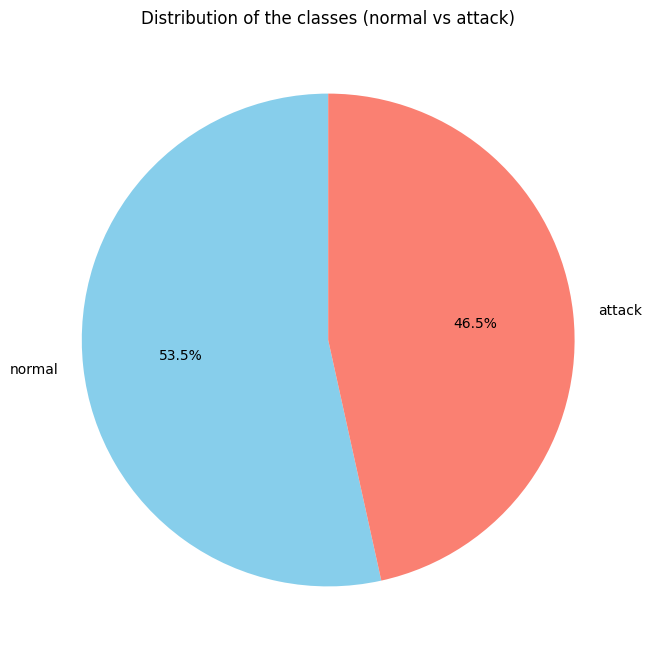

In [4]:
# Creating data to plot
class_counts = df['label'].value_counts()
plt.figure(figsize=(8, 8))
class_counts.plot.pie(autopct='%1.1f%%', labels=class_counts.index, colors=['skyblue', 'salmon'], startangle=90)
plt.title("Distribution of the classes (normal vs attack)")
plt.ylabel("") 
plt.show()

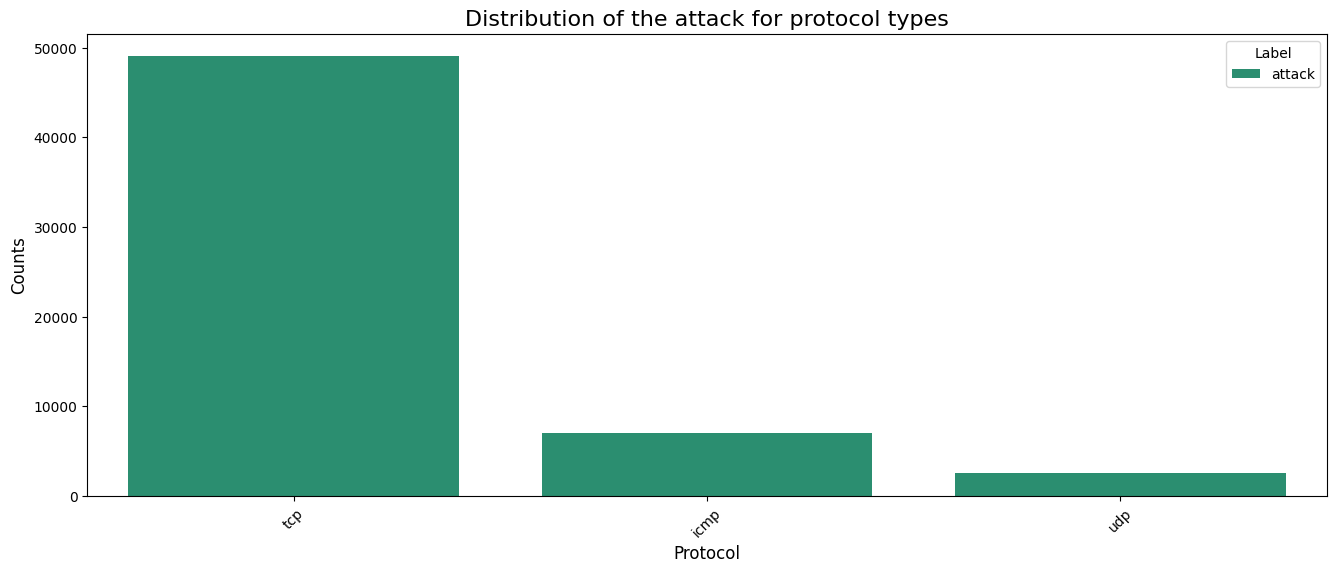

In [5]:
plt.figure(figsize=(16, 6))
sns.countplot(x='protocol_type', data=df[df['label'] == "attack"], hue='label', palette='Dark2')
plt.xticks(rotation=45)
plt.title('Distribution of the attack for protocol types', fontdict={'fontsize': 16})
plt.xlabel('Protocol', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.legend(title='Label', loc='upper right')
plt.show()

# Preprocessing

The KDD dataset contains several categorical features, such as protocol_type, service, flag, and label, which need to be encoded into numerical values to allow machine learning models to process them effectively.

In [6]:
le = LabelEncoder()
df['protocol_type']=le.fit_transform(df['protocol_type'])
df['service']=le.fit_transform(df['service'])
df['flag']=le.fit_transform(df['flag'])
df['label']=le.fit_transform(df['label'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  int64  
 2   service                      125973 non-null  int64  
 3   flag                         125973 non-null  int64  
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

# Helping Function

In [7]:
def plot_confusion_matrix(y_true, y_pred, labels=None, cmap=plt.cm.viridis, values_format='d'):
    """
    Function to compute and display the confusion matrix.
    
    Args:
    - y_true: array-like, true labels.
    - y_pred: array-like, predicted labels from the model.
    - labels: list, class labels (default: None, will be determined automatically).
    - cmap: Colormap for the confusion matrix (default: plt.cm.viridis).
    - values_format: Format for the values in the matrix (default: 'd' for integers).
"""
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Visualizza la matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, values_format=values_format)
    plt.show()



# Splitting the dataset

Before training a machine learning model, it is essential to divide the dataset into training and testing sets to evaluate the model's performance on unseen data.

- Training Set: The training set is used to train the model. During this phase, the model learns the patterns and relationships in the data that allow it to make predictions.

- Testing Set: The testing set is used to evaluate the model's performance. It is important that the testing data is kept separate from the training data to ensure that the model can generalize to new, unseen data. Using a separate testing set helps to avoid overfitting, which occurs when a model is too closely tied to the training data and performs poorly on new data.

In [8]:

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
# Split the data into training (80%) and temporary validation + test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the temporary validation + test set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now you have:
# X_train, y_train: Training set (80% of the data)
# X_val, y_val: Validation set (10% of the data)
# X_test, y_test: Test set (10% of the data)

# Scaling

Scaling ensures all features are on the same scale, improving model performance. We initially tried RobustScaler, which is designed to handle outliers, but it reduced accuracy, likely because the KDD dataset lacks significant outliers or the scaling disrupted feature relationships.

MinMaxScaler was chosen instead as it scales features to a 0-1 range, preserving their relationships. We fit the scaler on the training set and transformed both training and test sets to avoid data leakage. This approach improved accuracy, making MinMaxScaler the better choice.

In [9]:
scaler = MinMaxScaler()
# Fit the scaler to the features and transform them
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Transform the test data using the same scaler (no fit here to avoid data leakage)
X_test_scaled = scaler.transform(X_test)


# Correlation between attributes

Non stampiamo il plot perché non si riesce a vedere la correlazione tra la label e gli altri attributi con correlazione > perché è binaria (0,1) quindi non si vede.

In [27]:
corr_matrix = df.corr(numeric_only=True)

# Visualizzare le correlazioni per una specifica colonna (ad esempio 'median_house_value')
print(corr_matrix["label"].sort_values(ascending=False))  # Sostituire 'target_column' con la colonna target


label                          1.000000
same_srv_rate                  0.751913
dst_host_srv_count             0.722535
dst_host_same_srv_rate         0.693803
logged_in                      0.690171
flag                           0.647073
protocol_type                  0.281355
srv_diff_host_rate             0.119377
is_guest_login                 0.039279
num_access_files               0.036701
su_attempted                   0.022448
num_file_creations             0.021271
root_shell                     0.020285
hot                            0.013083
num_root                       0.011452
num_compromised                0.010198
num_shells                     0.009472
num_failed_logins              0.003755
urgent                         0.002787
is_host_login                  0.002629
srv_count                     -0.000771
dst_bytes                     -0.004118
src_bytes                     -0.005921
land                          -0.007191
duration                      -0.048785


# Logistic Regression

Logistic Regression's performance depends on the scale of input features. Without scaling, the accuracy was 88.6%, as features with different ranges hindered efficient gradient descent convergence. After applying MinMaxScaler, the accuracy improved to 95.53% on the test set. This highlights how scaling ensures all features contribute equally, avoiding dominance by features with larger ranges.

In [10]:
# 5. Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
 
# Predictions on the training and testing sets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Accuracy on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Training Accuracy: 0.9546
Testing Accuracy: 0.9512

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      5873
           1       0.94      0.97      0.95      6725

    accuracy                           0.95     12598
   macro avg       0.95      0.95      0.95     12598
weighted avg       0.95      0.95      0.95     12598



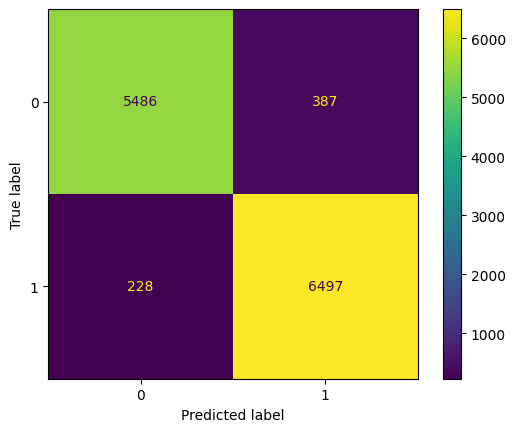

In [11]:
plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, labels=model.classes_)

# KNN

In [17]:

knn = KNeighborsClassifier()  # No need to specify n_neighbors initially

# Define the parameter grid to search
param_grid = {'n_neighbors': range(1, 10)}  # Testing n_neighbors from 1 to 20

# Perform GridSearchCV with 5-fold cross-validation on the training set
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameter and score
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

# Print the best parameters and score
print(f"Best number of neighbors: {best_n_neighbors}")
print(f"Best cross-validation score (Training): {best_score:.4f}")

# Use the best model to predict on the validation set for tuning
best_knn = grid_search.best_estimator_
y_val_pred = best_knn.predict(X_val_scaled)

# Accuracy and "loss" on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_loss = 1 - val_accuracy
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Predictions on the test set
y_test_pred = best_knn.predict(X_test_scaled)

# Accuracy and "loss" on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_loss = 1 - test_accuracy
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

# Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

Best number of neighbors: 1
Best cross-validation score (Training): 0.9965
Validation Accuracy: 0.9953
Validation Loss: 0.0047
Testing Accuracy: 0.9967
Testing Loss: 0.0033

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5873
           1       1.00      1.00      1.00      6725

    accuracy                           1.00     12598
   macro avg       1.00      1.00      1.00     12598
weighted avg       1.00      1.00      1.00     12598



# Decision Tree

La nostra preoccupazione era che andasse in overfitting ma facenda post pruning ci ha dato conferma che l'albero non venisse potato (alpha 0.0), di conseguenza il modello si comporta bene come indicato dall'accuratezza del 99.79% sul test set e dal class report eccellente.  

In [38]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
# Ottenere i valori di ccp_alpha per la potatura
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # Escludiamo l'ultimo valore (albero con solo radice)

# Creare e testare alberi con diversi valori di ccp_alpha
best_alpha = None
best_accuracy = 0
for alpha in ccp_alphas:
    clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf_pruned.fit(X_train, y_train)
    y_pred = clf_pruned.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    
    if acc > best_accuracy:  # Troviamo l'alpha con miglior accuratezza
        best_accuracy = acc
        best_alpha = alpha

# Allenare l'albero finale con il miglior alpha
clf_final = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_final.fit(X_train, y_train)

# 8. Valutazione sul validation set
y_pred_val = clf_final.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print("\nBest Alpha:", best_alpha)
print("Validation Accuracy with Best Alpha:", val_accuracy)

# 9. Valutazione sul test set
y_pred_test = clf_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy with Best Alpha:", test_accuracy)

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred_test))



Best Alpha: 0.0
Validation Accuracy with Best Alpha: 0.9978566325315551
Test Accuracy with Best Alpha: 0.9979361803460867

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5873
           1       1.00      1.00      1.00      6725

    accuracy                           1.00     12598
   macro avg       1.00      1.00      1.00     12598
weighted avg       1.00      1.00      1.00     12598



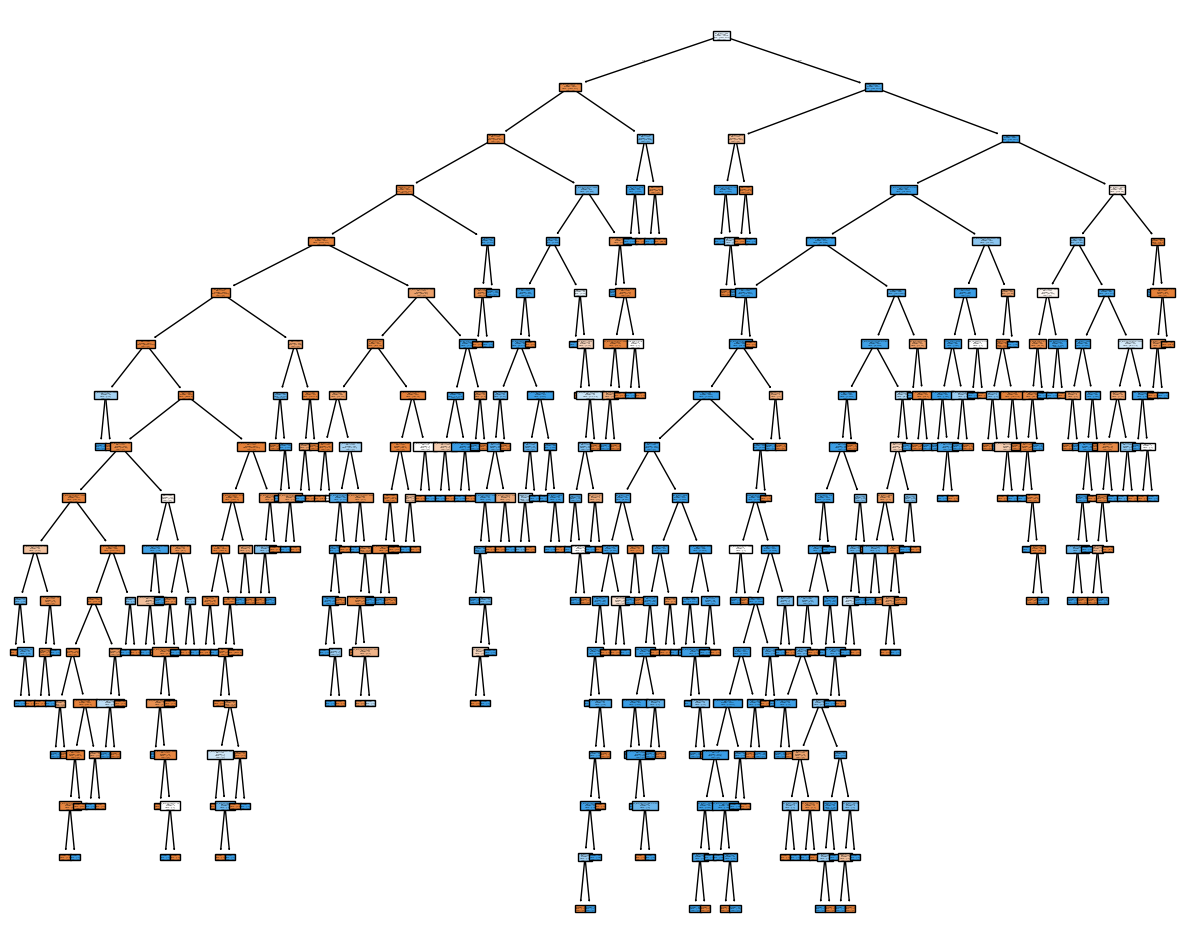

In [31]:
fig = plt.figure(figsize=(15, 12))
plot_tree(clf_final, filled=True, feature_names=X.columns, class_names=True)
plt.show()

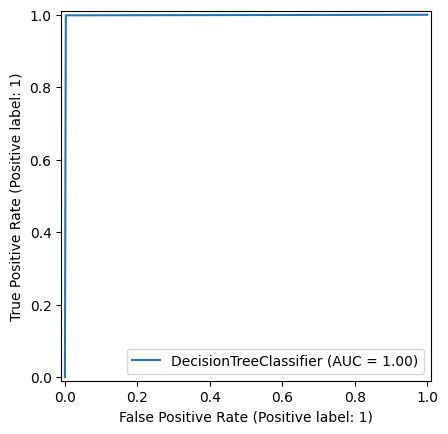

In [40]:
# 10. ROC Curve Plot
# Calcoliamo le probabilità per la ROC curve
y_pred_prob = clf_final.predict_proba(X_test)

# Plottiamo la ROC curve
RocCurveDisplay.from_estimator(clf_final, X_test, y_test, response_method="predict_proba")
plt.show()

# Neural Network

splitting for validation set

In [26]:
# Step 1: Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
# Fit the scaler to the features and transform them
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (no fit here to avoid data leakage)
X_test_scaled = scaler.transform(X_test)

# Fit the scaler to the features and transform them
X_val_scaled = scaler.fit_transform(X_val)



In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train_scaled.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

/home/aries/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1738074327.153019    8450 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [28]:


model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,849 (558.00 KB)

 Trainable params: 142,849 (558.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                               patience=5,        # Number of epochs with no improvement after which training will stop
                               verbose=1,          # Print messages when early stopping is triggered
                               restore_best_weights=True)  # Restore the best weights after training stops

# Train the model with the EarlyStopping callback
history = model.fit(X_train_scaled, y_train, 
                    epochs=100,           # Maximum number of epochs
                    batch_size=32,        # Batch size
                    validation_data=(X_val_scaled, y_val),  # Validation data to monitor performance
                    callbacks=[early_stopping])  # Add the early stopping callback
#history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=5, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9484 - loss: 0.2284

KeyboardInterrupt: 